Import standard modules:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import HTML 
HTML('../style/course.css') #apply general CSS

Import section specific modules:

In [2]:
from IPython.display import Image
import scipy.signal

In [3]:
HTML('../style/code_toggle.html')

***

##  Analogue Electronics

### 1 An Idealized Source<a id='instrum:sec:7_3_1'></a>

Let us ignore interferometry for now, and consider a single radio telescope. For a simple sky containing only a single source, what would we expect to observe? The source should have some intrinsic flux $I$ (measured in Janskys) and some spectral index $\alpha$ of the form

$$
I(\nu) = I_0 \left( \frac{\nu}{\nu_0} \right)^{-\alpha}
$$

where $I_0$ is the source's flux at some reference frequency $\nu_0$. We think of most radio sources as being stable over long lifetimes. The source flux will thus not change noticably over short periods of time. Though the signal we are measuring is a time-domain signal, we will look at the frequency spectrum throughout this section. Frequency is what we are ultimately interested in for now. If we were to plot the source's flux as a function of time and observing frequency in a *waterfall plot*, it would look like the figure below:

In [4]:
# Setup an ideal source coherency spectrum
nchans = 512 # number of frequency channels
freq0 = 1.1e9 # start frequency (Hz) (centre of first channel)
freq1 = 1.5e9 # stop frequency (Hz) (centre of last channel)
freqs = np.linspace(freq0, freq1, nchans)
ntime = 500

I0 = 1. # flux at reference frequency (Jy)
nu0 = 1.421e9 # reference frequency (Jy)
alpha = -0.25 # source spectral index
Inu = lambda nu: I0 * (nu/nu0)**alpha # Stokes I spectrum

# Stokes Parameters
I = Inu(freqs)
Q = np.zeros_like(I)
U = np.zeros_like(I)
V = np.zeros_like(I)

# Compute the polarisation values
brightness = np.empty(shape=(nchans, 2, 2), dtype=np.complex128)
brightness[:,0,0] = I + Q
brightness[:,0,1] = U + V*1j
brightness[:,1,0] = U - V*1j
brightness[:,1,1] = I - Q

brightness = np.tile(brightness[np.newaxis], [ntime, 1, 1, 1])

/home/shreyam/miniconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/shreyam/miniconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 0.98, 'Idealized Source Spectrum')

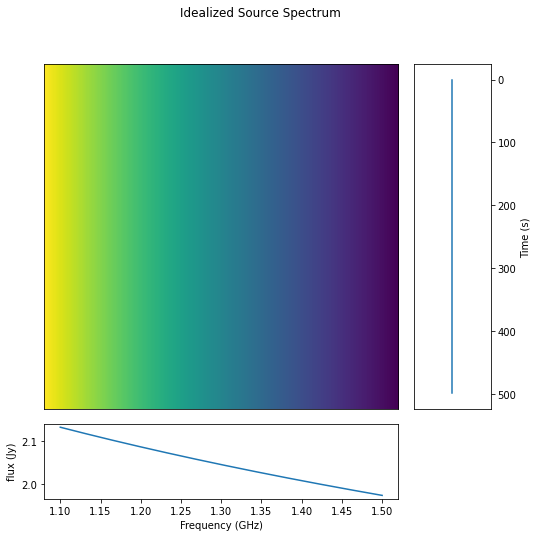

In [5]:
fig, axes = plt.subplots(figsize=(8,8))

ax1 = plt.subplot2grid((5,5), (0,0), colspan=4, rowspan=4)
plt.imshow(np.abs(brightness[:,:,0,0]+brightness[:,:,1,1]), aspect='auto')
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)

ax2 = plt.subplot2grid((5,5), (4,0), colspan=4, rowspan=1)
plt.plot(freqs/1e9, brightness[10,:,0,0]+brightness[10,:,1,1])
plt.ylabel('flux (Jy)')
plt.xlabel('Frequency (GHz)')

ax3 = plt.subplot2grid((5,5), (0,4), colspan=1, rowspan=4)
plt.plot(brightness[:,10,0,0]+brightness[:,10,1,1], np.arange(brightness.shape[0]))
ax3.get_xaxis().set_visible(False)
ax3.invert_yaxis()
ax3.yaxis.tick_right()
plt.ylabel('Time (s)')
ax3.yaxis.set_label_position('right')

plt.suptitle('Idealized Source Spectrum')

The bottom plot shows the spectrum for a single moment in time, and the plot on the right shows the flux at a single frequency. The source is stable in time and frequency. This is what we would like to detect. Of course, things are not so simple in practice...any system we build will introduce noise into the measurement. Furthermore, as we have hinted at, our measurement systems alters the original signal! Instead of this nice, ideal measurement we then see something like the waterfall plot at the end of this section. We will step through the various stages of an example analogue front-end to understand why the observed spectrum differs from the original source spectrum.

### 2 System Noise and Sensitivity

All measurement systems have noise. In fact, anything which is not at absolute zero (i.e. everything) has some energy, which is radiated as heat; another term for heat is noise. We are interested in measuring some signal. If our system introduces too much noise into the measurement, then we can not recover the original signal. When we discuss the *sensitivity* of a telescope, we are primarily interested in how much noise the system adds during measurement. This *system noise* is, among other things, a result of electronic components, the telescope's engineering design (antenna feed, dish design, etc.), and sky signals. Newer electronic components tend to have lower noise characteristics than older systems. Telescopes are thus often upgraded with newer systems.

#### Noise as Temperature

It is very common to discuss noise in terms of temperature. Noise is a consequence of heat, and heat is measured as a temperature. From an electronics perspective, we can consider a signal as a voltage in an electrical circuit. The signal is then a Johnson-Nyquist noise source, and the power dissapated by that noise source is:

$$P = k_B T \Delta \nu$$

Where $P$ is the power of the voltage signal, $k_B$ is the Boltzmann constant, $T$ is temperature in Kelvin, and $\Delta \nu$ is the bandwidth of the signal in Hertz. The noise power of a radio telescope (or a thereof) is thus often described in the literature in terms of a temperature

$$T = \frac{P}{k_B \Delta \nu}$$

#### System Temperature

If we want to determine a telescope's sensitivity, we must first understand its noise characteristics. We can then decide if it is possible to detect the signal we are after. We start by assuming that there is some temperature which defines our telescope's noise characteristics. As you might expect, this is the *system temperature*, and is made up of multiple components

$$ T_{\textrm{sys}} = T_{\textrm{sky}} + T_{\textrm{atmosphere}} + T_{\textrm{spillover}} + T_{\textrm{rx}} + \ldots$$

where $T_{\textrm{sky}}$ is the stochastic signal from the sky. In the L-band (1.4 GHz) the sky temperature is approximately 10 K, 2.73 K of which are from the Cosmic Microwave Background (CMB). The sky temperature varies depending on the observing frequency,: at low frequency - say 100 MHz -, for example, the sky is close to 1000 K . This is primarily due to synchrotron radiation. We can approximate a 'room temperature' on Earth as 300 K. If the sky noise is significantly 'hotter' than room temperature, then there is clearly little advantage to building instruments with low noise characteristics.

Depending on the observing freqency, a component of noise is also due to the atmosphere and ionosphere: $T_{\textrm{atmosphere}}$. Though this noise is "natural", we nevertheless treat it as part of the observing system. If our telescope was placed on the moon, then there would be essentially no atmospheric noise. In the L-band this is a small noise effect ($\sim 1$ K); the phase rotation effects discussed later in the chapter are a much more serious effect.

The Earth is a 300 K black-body radiation source, i.e. a very hot noise source. We would like to block the noise from the earth (known as *ground noise*) before it enters our measurement system. This can be done in two ways: cooling the electronics, and/or isolating the system. One way the ground noise enters the system is from the primary beam's illumination pattern. We will discuss primary beams later. For now, what matters is that the telescope optics produce a 'beam', which is sensitive to all locations on the sky. The optics are designed such that the beam is most sensitive to the direction towards which the dish is pointed, but there is always some sensitivity in other directions. Thus, no matter where we point the telescope, it is always sensitive - to some extent - to signal from the ground. If the telescope is pointed low on the horizon, an even more sensitive section of the beam will be pointed at the ground. This is called *spillover noise* $T_{\textrm{spillover}}$, and is a pointing direction-dependent noise term. If the integrated spillover is on the order of a few precent, this can result in noise of the order of 10's of Kelvin.

The final term of note in the system temperature is the receiver noise: $T_{\textrm{rx}}$. This is the noise introduced into the measurement by the analogue electronics used to convert the weak sky signal into a digital signal which can be recorded. A KAT-7 or MeerKAT telescope produce approximately 20 K in receiver noise. We will discuss the analogue receiver system further in the rest of this section.

#### Radiometer Equation

For a single radio telescope, the measurement of the average power over some bandwidth for a direction in the sky is done with a *radiometer*. Given that the noise signal we are measuring is approximately Gaussian, the error of the measured signal can be described by the *ideal radiometer equation*

$$
\sigma_{T} = \frac{T_{\textrm{sys}}}{\sqrt{\Delta\nu \tau}}
$$

where $\sigma_{T}$ is the standard deviation of the measured noise temperature about the true noise temperature. The radiometer equation describes the necessary bandwidth ($\Delta \nu$) and integration time ($\tau$) required to reach a desired noise level ($\sigma_{T}$) for an ideal system with a given system temperature ($T_{\textrm{sys}}$) when observing a broadband source.

From the radiometer equation we can see that a linear decrease in system temperature will lead to a linear reduction in $\sigma_{T}$. A linear increase in the bandwidth or intergration time only leads to square-root improvement in $\sigma_{T}$. For example, If there are two systems, with the same bandwidth $\Delta \nu$, in which one has a system temperature twice that of the other, i.e. $T_{\textrm{sys,0}} = 2 T_{\textrm{sys,1}}$, then $T_{\textrm{sys,0}}$ will take 4 times longer to reach the same sensitivity as $T_{\textrm{sys,1}}$.

The radiometer equation above holds for an ideal system, but real-life analogue systems are unstable and introduce 'gain fluctuations'. These fluctuations are due to a number of effects: the physical temperature of the electronics, cross-coupling leakage, RF shielding, etc. The system stability over an observation will depend on how well these effects are managed. These gain fluctuations depend on both time and frequency.

#### System Equivalent Flux Density (SEFD)

The overall sensitivity of a radio telescope is described by the *system equivalent flux density* (SEFD) which is a ratio of the noisiness of the instrument ($T_{\textrm{sys}}$) to the effective signal *gain* $G_{eff}$. Here, "gain" is a catch-all term for all the various amplifications and attenuations of the sky signal we are interested in. Formally the SEFD is defined as

$$
\textrm{SEFD} = \frac{T_{\textrm{sys}}}{G_{eff}} = \frac{2 k_B \eta T_{\textrm{sys}}}{A_{eff}}
$$

where $k_B$ is the Boltzman constant, $\eta$ is an generic efficiency factor (always *greater* than 1 - not a typo!) used to represent the signal loss in various system temperature components of the telescope (e.g. dish surface inefficiencies, feed under-illumination, quantization, etc...), and $A_{eff}$ is the effective collecting area of the telescope. For a dish telescope $A_{eff}$ can be approximated, to first order, as the geometric surface area of the dish.

A decrease in the SEFD is equivalent to an improvement in the sensitivity of the telescope.

### 3 Analogue Receiver Front-End

To understand the details of the system's temperature and gain, we need to start with the *analogue receiver front-end*, also known as the analogue chain. This is the set of analogue electronic components which are used to condition the weak sky signal in order to do digital computations (like correlation). Ideally, we prefer a digital signal for a number of reasons. Digital signals are predictable, and any computation is deterministic. It is easier to perform operations such as Fourier transforms and correlations on digital signals than to analogue signals. An advantage of analogue signals is that they are continuous: they are free of issues due to Nyquist sampling or aliasing. Analogue components, however, are affected by feedback, cross-talk, temperature, and power supplies. Worst of all, analogue components introduce noise into the signal! In general, analogue components produce variable response in time and frequency, whereas a digital system has a stable response in time and frequency.

We would like to digitize our sky signal as soon as possible. Unfortunately, the sky signal is very weak, and needs to be amplified and conditioned before it can be converted to digital. The *analogue-to-digital converter* (ADC) transforms an analogue signal to a digital signal, but if the signal is too weak then the ADC cannot sample the analogue signal. Below is a block diagram of an example analogue front-end.

*Amplification* is the effect of increasing the strength of a signal absolutely or relative to another signal. In electronics an amplifier might be used for this, but other forms of amplification are possible, e.g. building a larger dish to collect more signal. The opposite effect is called *attenuation*. This amplification (attenuation can also be seen as an amplification less than 1) can be complex or real-valued, and a function of time, frequency, or direction. Some operations will have unity gain, e.g. a rotation transform. Signal *conditioning* is the application of different filters to select out a limited signal of interest.

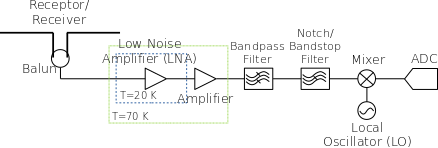

In [3]:
Image("analogue_chain.png")


**Figure 1**: Block diagram example of an analogue receiver front-end for a radio telescope. A current is induced in the receptor by the electric field of the sky source. The resistance of the components creates a voltage which is propotional to the amplitude of the electric field. This voltage is amplified by a low noise amplifier (LNA) in a cryostat at 20 K. A second stage amplifier further amplifies the signal in a 70 K intermediate cryostat. The signal is bandpass filtered to select the band of interest. A bandstop filter is used to filter out frequencies with radio frequency interference (RFI). A local oscillator (LO) is mixed with the signal to down mix the original radio frequency (RF) to an intermediate frequency (IF) which is then digitized by an analogue-to-digital converter (ADC). <a id='instrum:fig:analogue_chain'></a><!--\label{instrum:fig:analogue_chain}-->

The electric field of the sky signal induces a current on the *receptor* (also known as a *feed*). This is a very weak signal: we need to use an amplifier to increase the strength of the signal. The process of amplification introduces noise, which we would like to minimize. As technology improves, the noise introduced by amplifiers has decreased. The common method to reduce the noise of an amplifier is by cooling it using a *cryostat*. This is a chamber placed under vacuum, which can be cooled down to very low temepratures (20 K if using liquid helium, 70 K for liquid nitrogen). Remember - noise and temperature are the same, so the lower the temperature, the lower the noise. This special amplifier is called a *low noise amplifier* (LNA), and is usually the main component of the system noise. When building a telescope system, we focus on making sure the LNA has the best possible noise performance (i.e. the LNA is a significant cost to the analogue front end).

The idea of the LNA is that we have a weak signal which needs to be amplified while adding the smallest possible amount of noise into the signal. Once the signal has been amplified with the LNA, we can use normal amplifiers and apply filters, because the signal to noise ratio is now sufficiently large that the added noise from these components will not affect the original signal very much. This can be seen in the receiver temperature equation.

$$ T_{\textrm{rx}} = T_{\textrm{feed}} + \frac{T_{\textrm{passive}}}{G_{\textrm{feed}}} + \frac{T_{\textrm{LNA}}}{G_{\textrm{feed}} G_{\textrm{passive}}} + \frac{T_{\textrm{amp}}}{G_{\textrm{feed}} G_{\textrm{passive}} G_{\textrm{LNA}}} + \ldots$$

where the $T$ terms are the additional noise temperatures introduced by each component, and $G$ is the 'gain' term  - which can be less than 1 (attenuation) or greater than 1 (amplification). The gain from the feed and passive components will be less than 1, and are similar to an efficiency term in when discussing the primary beam. These will cause the temperature from these components to increase in the system temperature. By placing the LNA as soon as possible, we see that the weak sky signal is amplified and noisier components - such as filters and second stage amplifiers - can be introduced without drowning the sky signal in their noise.

From the receiver temperature equation above, we can see that each additional temperature term includes the gain of the LNA in the denominator. Thus, the more gain is introduced by the LNA, the smaller each additional noise term. There are some noise terms which come before the LNA stage. There is always a feed temperature $T_{\textrm{feed}}$ (any physical feed will have some resistance - else, there would be no current!). There are passive components such as cables, orthomode transducers (OMTs), waveguides etc. which all add a noise component $T_{\textrm{passive}}$.

#### Decibel Units

As a quick aside, it is common to discuss electronic and system gain using logarithmic decibel units. This is worth a quick review. We usually describe a signal in linear units. It is often more intuitive, however, to use logarithmic units when discussing values which cover many orders of magnitude, such as in electronics. The standard unit to use is the *decibel*, which is defined (for a power $P$) as:

$$
P_{dB} = 10 \log_{10} \left ( \frac{P}{P_0} \right )
$$

where $P_0$ is the reference power, typically set to unity. Important values to remember are: 3 dB is a factor of 2 increase, 10 dB is a factor of 10, -3 dB is a factor of 0.5. Every factor of 10 increase in decibels is an order of magnitude increase. Note that if the signal is not a power (e.g. it is a voltage or electric field) the definition of decibel is

$$
P_{dB} = 20 \log_{10} \left ( \frac{V}{V_0} \right )
$$

as we need to compute the power of the voltage in the process of converting to decibels. 

Returning to the LNA in our analogue front-end example, we typically amplify the sky power signal by 20 to 30 decibels with the LNA. That is, the LNA amplifies the sky signal by a factor of 100 to 1000. We can then use other components without worrying about introducing significant noise relative to the signal strength.

Below is an example of the LNA response in time and frequency. This is a simple model, where the LNA bandpass response is stable in time but the overall system gain varies in time. The bandpass has a frequency-dependent response that ranges between 30 dB and 20 dB. There is a'ripple' across the band due to the LNA design. The LNA peaks around 1.2 GHz and drops off at higher frequencies. The overall gain varies by a few precent over time, which can be due to a number of effects. The heating and cooling of the cryostat is never perfect, so there is variation in the gain. Depending on the observing source, we should expect the gain to change: a bright source will introduce more noise than a dimmer source. Feedback and cross-talk between analogue components will always exist even with good isolation. This is thus a fairly typical LNA response, such as one could expect to see in real life.

Text(0.5, 0.98, 'LNA Response')

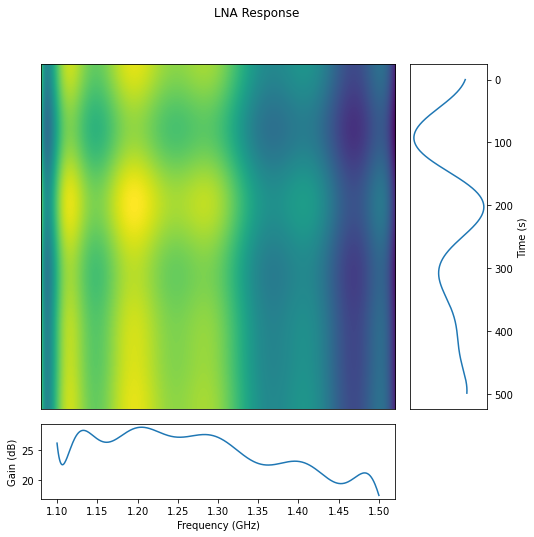

In [6]:
#LNA bandpass
#xrange: 0,1
#yrange: 20-30 dB
#a made up LNA response spectrum (in dB)
nfreqVals = np.array([-0.5, 0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45,
                  0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0, 1.05])
lnaVals = np.array([27, 27, 28.1, 28, 27.5, 29, 30.1, 30, 28.5, 28.5, 30,
                  27, 27, 25.5, 23, 24, 25, 22.5, 21, 21, 22, 19.5, 19.5])

#add a little noise for randomness
lnaStd = 0.5 #standard deviation of noise in dB
noiseVals = np.random.normal(loc=0.0, scale=lnaStd, size=lnaVals.shape)

nfreqs = np.linspace(0, 1, num=nchans) #normalized frequencies
coeffs = np.polyfit(nfreqVals, lnaVals + noiseVals, deg=15)
lnaGain = 10.**(np.polyval(coeffs, nfreqs)/10) #convert to linear

#Gain variation
#xrange: 0,1
#yrange: 1 + std
tVals = np.linspace(-0.5, 1.5, num=60)
gainStd = 0.10
gVals = np.random.normal(loc=1.0, scale=gainStd, size=tVals.shape)

ts = np.linspace(0, 1, num=ntime)
gCoeffs = np.polyfit(tVals, gVals, deg=20)
gain = np.polyval(gCoeffs, ts)

gainSpectrum = np.outer(gain, 10. * np.log10(lnaGain))

fig, axes = plt.subplots(figsize=(8,8))

ax1 = plt.subplot2grid((5,5), (0,0), colspan=4, rowspan=4)
plt.imshow(np.abs(gainSpectrum), aspect='auto')
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)

ax2 = plt.subplot2grid((5,5), (4,0), colspan=4, rowspan=1)
plt.plot(freqs/1e9, gainSpectrum[100, :])
plt.ylabel('Gain (dB)')
plt.xlabel('Frequency (GHz)')

ax3 = plt.subplot2grid((5,5), (0,4), colspan=1, rowspan=4)
plt.plot(gainSpectrum[:, 100], np.arange(gainSpectrum.shape[0]))
ax3.get_xaxis().set_visible(False)
ax3.invert_yaxis()
ax3.yaxis.tick_right()
plt.ylabel('Time (s)')
ax3.yaxis.set_label_position('right')

plt.suptitle('LNA Response')

#### Filters

Applying *signal filters* to the observed signal is necessary for a number of reasons. We are limited to a finite observing bandwdith, because our antenna feed is only sensitive to a limited frequency range. The LNA is only well-characterized for a limited bandwidth, human-made radio interference limits the usable observing band, the ADC only Nyquist samples up to a specific bandwidth before aliasing occurs, etc. All these factors define the usable bandwidth of the instrument. There will be a *start frequency* $\nu_0$ - which is the lowest frequency the system records data at - and a *stop frequency* $\nu_f$ - which is the highest frequency. The range within these frequencies is the *bandwidth* $\Delta \nu = \nu_f - \nu_0$. We can further define two types of bandwidth: the *analogue bandwidth* is the bandwidth of the system based on the analogue filters, and the *digital bandwidth* is defined by half the sampling rate of the ADC (i.e. the digital bandwidth is set by the Nyquist rate). 

The two building blocks of signal filtering are the *high-pass filter*, which supresses low-frequency signals while leaving high-frequency signals untouched, and the *low-pass filter* which does the opposite. Filter design is an active field of study, and a lifetime can be spent on the topic - we will not go into any depth, but merely present the basics needed to understand a radio telescope analogue front end.

A filter works by applying a weighted average in the time domain using some number of samples (called *taps*). The weights within the filter are defined by a window function. A simple window function is a boxcar or truncated Gaussian, but there are many types depending on the desired response. When the time domain signal is transformed into the frequency domain, the window function's Fourier transform is called the *window response function*. The window response of a boxcar is the sinc function, and the response of a Gaussian filter is another Gaussian.

To set the band of the analogue system we use a *bandpass filter* which consists of a low-pass and high-pass filter to created a limted band response. An example of a bandpass filter using a low-pass and high-pass Hann window with 33 taps is shown below. These are *finite-impulse response filters* (FIRs) which are typically used for bandpass filters. Another type of filter is the *infinite-impulse response filter* (IIRs) which we will not discuss further.

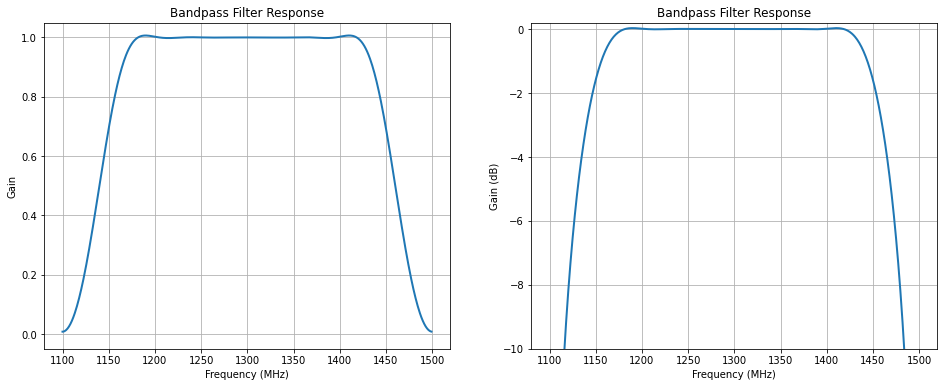

In [7]:
# Modified from: https://scipy.github.io/old-wiki/pages/Cookbook/FIRFilter.html
# The Nyquist rate of the signal.
sample_rate = 800.0 # ADC sampling rate (MHz)
nyq_rate = sample_rate / 2.0 # Digital Bandwidth

# Low-Pass Filter
# The cutoff frequency of the filter.
lpf_cutoff_hz = 360. # MHz
# Use firwin with a Hann window to create a low-pass FIR filter.
lpf_taps = scipy.signal.firwin(33, lpf_cutoff_hz/nyq_rate, window='hann')

# High-Pass Filter
# The cutoff frequency of the filter.
hpf_cutoff_hz = 40. # MHz
# Use firwin with a Hann window to create a high-pass FIR filter.
hpf_taps = scipy.signal.firwin(33, hpf_cutoff_hz/nyq_rate, window='hann', pass_zero=False)

lpf_w, lpf_h = scipy.signal.freqz(lpf_taps, worN=512)
hpf_w, hpf_h = scipy.signal.freqz(hpf_taps, worN=512)
lpfAmp = np.absolute(lpf_h)
hpfAmp = np.absolute(hpf_h)
bandpassAmp = lpfAmp*hpfAmp

fig, axes = plt.subplots(figsize=(16,6))

plt.subplot(1, 2, 1)
plt.plot((freq0/1e6)+(lpf_w/np.pi)*nyq_rate, bandpassAmp, linewidth=2)
plt.xlabel('Frequency (MHz)')
plt.ylabel('Gain')
plt.title('Bandpass Filter Response')
plt.ylim(-0.05, 1.05)
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot((freq0/1e6)+(lpf_w/np.pi)*nyq_rate, 10.*np.log10(bandpassAmp), linewidth=2)
plt.xlabel('Frequency (MHz)')
plt.ylabel('Gain (dB)')
plt.title('Bandpass Filter Response')
plt.ylim(-10, 0.2)
plt.grid(True)

Designing the bandpass filter depends on a number of factors, including desired bandwidth, out-of-band suppression, and financial cost. Filter design is an engineering challenge, set by the project specifications. We will not attempt to cover the topic; see [<cite data-cite='Lyons:2004:UDS:993484'>Understanding Digital Signal Processing</cite> &#10548;](https://books.google.co.za/books?id=UBU7Y2tpwWUC) for an introduction. As far as we are concerned, there are a few important characteristics. *Usable band*: this is the amount of band which can be used for observation, in the example above this is approximately 1175 MHz to 1425 MHz. *Roll-off*: this is the rate at which the filter drops in response. There is a transtion region in our example from 1100 MHz to 1175 MHz between the bandpass and bandstop regions. *Bandpass ripple*: we see that the bandpass is not perfectly flat;there is variation, especially when the filter begins to roll-off. We would like a nearly flat response across the band. The filter is continuous in frequency, so even though we would like to put a hard stop to the filter at 1100 MHz and 1500 MHz, the response is non-zero. We will be sampling the analogue signal at some Nyquist rate, which will create aliasing effects. We need to have a low enough filter response at the start and stop frequencies that signals from out of the band do not alias into the band. The cost of supressing aliasing is to reduce the overall usable band, or require sharper filters.

The opposite of a bandpass filter is a *bandstop filter* which supresses signals within a limited frequency range. These are useful in radio astronomy to supress *radio frequency interference* (RFI) which is strong human-made radio signals. RFI can be orders of magnitude stronger than astronomical signals. Signals such as those of mobile telephones at 800 MHz and FM radio around 100 MHz (among many others) are present in most populated regions of the Earth.

We can partially seperate out the RFI from astronomical signals when the observed signal is channelized, but before that, RFI can cause issues with the analogue front-end due to the dynamic range of the electronic components. Any analogue electronic component is designed with a limited input amplitude range, kown as the device's *dynamic range*. Within this dynamic range, the device has a *linear response*, i.e. the output can be directly mapped to the input based on a linear scaling relation. Input signals out of the dynamic range produce a non-linear response, along with feedback which can affect other components. We would like to build analogue electronics which are optimized to detect astronomical signals, and so we filter out strong RFI signals before these components are used. In the case of strong, persistent, narrow-band RFI (such as FM radio and mobile telephones) a solution is to use a bandstop filter (or *notch filter*) to supress signals within a limited band around the RFI. Below is a simple spectrum which has three strong, narrow-band RFI source.

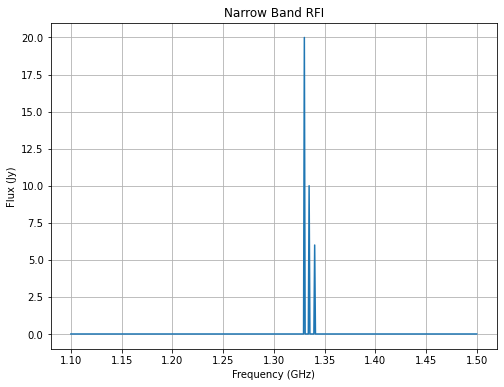

In [8]:
# Spectrum for strong, narrow-band RFI sources
rfiSpectrum = np.ones_like(freqs)
# Add RFI sources
rscale = 20.
idx = np.abs(freqs - 1.33e9).argmin()
rfiSpectrum[idx] += 1. * rscale
idx = np.abs(freqs - 1.34e9).argmin()
rfiSpectrum[idx] += 0.3 * rscale
idx = np.abs(freqs - 1.335e9).argmin()
rfiSpectrum[idx] += 0.5 * rscale

fig, axes = plt.subplots(figsize=(8,6))

plt.plot(freqs/1e9, rfiSpectrum-1)
plt.title('Narrow Band RFI')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Flux (Jy)')
plt.grid(True)

If we do nothing to supress the RFI the resulting observed spectrum dynamic range will be dominated by the RFI as shown below.

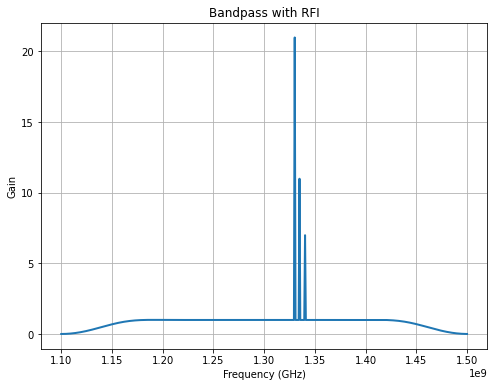

In [9]:
fig, axes = plt.subplots(figsize=(8,6))

plt.plot(freqs, bandpassAmp * rfiSpectrum, linewidth=2)
plt.xlabel('Frequency (GHz)')
plt.ylabel('Gain')
plt.title('Bandpass with RFI')
plt.grid(True)

To mitigate this, we can design a notch filter to supress 40 MHz of band around these sources. In the figure below, the filter is shown in linear and decibel scales. We can see the notch filter will supress signals up to -30 dB in amplitude.

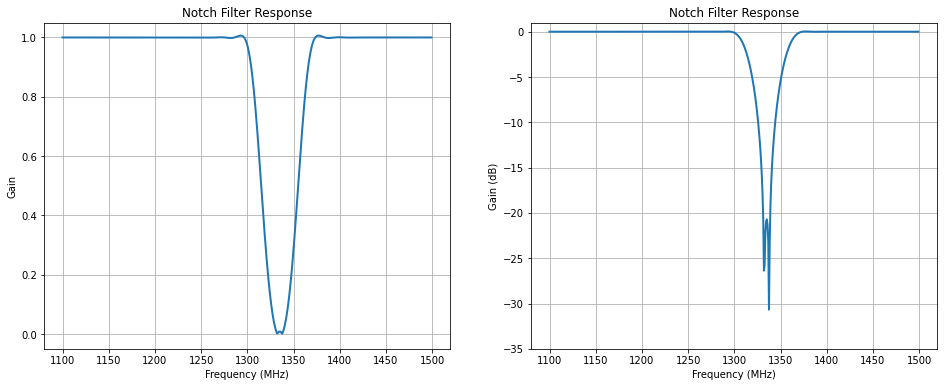

In [10]:
# Bandstop/Notch Filter
# The cutoff frequency of the filter.
bsf_cutoff_hz = np.array([215., 255.])
# Use firwin with a Hann window to create a low-pass FIR filter.
bsf_taps = scipy.signal.firwin(73, bsf_cutoff_hz/nyq_rate, window='hann')

bsf_w, bsf_h = scipy.signal.freqz(bsf_taps, worN=512)
bsfAmp = np.absolute(bsf_h)

fig, axes = plt.subplots(figsize=(16,6))

plt.subplot(1, 2, 1)
plt.plot((freq0/1e6)+(lpf_w/np.pi)*nyq_rate, bsfAmp, linewidth=2)
plt.xlabel('Frequency (MHz)')
plt.ylabel('Gain')
plt.title('Notch Filter Response')
plt.ylim(-0.05, 1.05)
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot((freq0/1e6)+(lpf_w/np.pi)*nyq_rate, 10.*np.log10(bsfAmp), linewidth=2)
plt.xlabel('Frequency (MHz)')
plt.ylabel('Gain (dB)')
plt.title('Notch Filter Response')
plt.ylim(-35, 1.)
plt.grid(True)

We can then combine the bandstop filter with the bandpass filter, shown below.

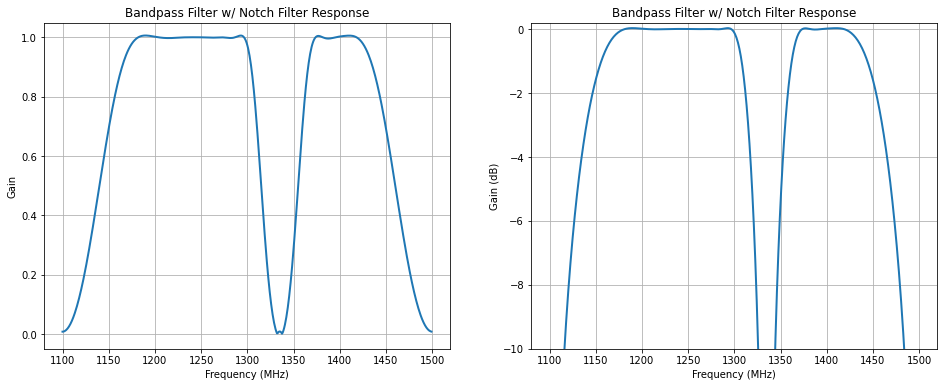

In [11]:
fig, axes = plt.subplots(figsize=(16,6))

plt.subplot(1, 2, 1)
plt.plot((freq0/1e6)+(lpf_w/np.pi)*nyq_rate, bandpassAmp*bsfAmp, linewidth=2)
plt.xlabel('Frequency (MHz)')
plt.ylabel('Gain')
plt.title('Bandpass Filter w/ Notch Filter Response')
plt.ylim(-0.05, 1.05)
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot((freq0/1e6)+(lpf_w/np.pi)*nyq_rate, 10.*np.log10(bandpassAmp*bsfAmp), linewidth=2)
plt.xlabel('Frequency (MHz)')
plt.ylabel('Gain (dB)')
plt.title('Bandpass Filter w/ Notch Filter Response')
plt.ylim(-10, 0.2)
plt.grid(True)

The resulting observed RFI signal (shown below) is significantly suppressed by the notch filter, at the cost of losing usable bandwidth. This trade-off that is often necessary.

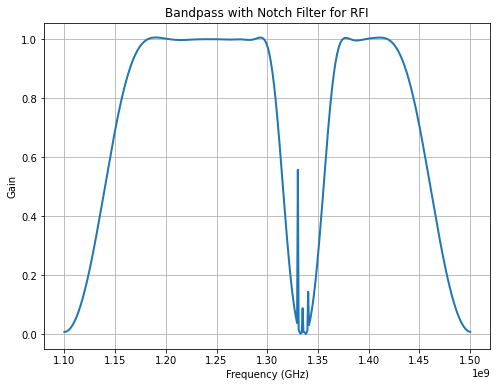

In [12]:
fig, axes = plt.subplots(figsize=(8,6))

plt.plot(freqs, bandpassAmp * bsfAmp * rfiSpectrum, linewidth=2)
plt.xlabel('Frequency (GHz)')
plt.ylabel('Gain')
plt.title('Bandpass with Notch Filter for RFI')
plt.grid(True)

#### Hetrodyne Mixing

After the filters in our block diagram analogue front-end example, there is a mixer with a local oscillator. This is know as a *hetrodyne detection*, which is the process of 'mixing' down the original radio frequencies (RF) $\nu_{\textrm{RF}}$ to an intermediate frequency (IF) $\nu_{\textrm{IF}}$ using a local oscillator (LO) $\nu_{\textrm{LO}}$ such that the signal can be sampled digitally. A *local oscillator* is a pure, single-frequency tone. Mixing of the RF and LO results in $\nu_{\textrm{IF}} = \nu_{\textrm{RF}} - \nu_{\textrm{LO}}$. Consider two pure sine waves $\sin(2 \pi \nu_{\textrm{RF}})$, $\sin(2 \pi \nu_{\textrm{LO}})$, mixing is the process of multiplying the signals together, using trigonomic identities this results in

$$\sin(2 \pi \nu_{\textrm{RF}}) \cdot \sin(2 \pi \nu_{\textrm{LO}}) = \frac{1}{2} \cos(2 \pi (\nu_{\textrm{RF}} - \nu_{\textrm{LO}})t) + \frac{1}{2} \cos(2 \pi (\nu_{\textrm{RF}} + \nu_{\textrm{LO}})t) $$

Because we have used a bandpass filter, any signal above the stop frequency will be suppressed, so the $\cos(2 \pi (\nu_{\textrm{RF}} + \nu_{\textrm{LO}})t)$ term can be dropped, resulting in a mixer output of $\frac{1}{2} \cos(2 \pi (\nu_{\textrm{RF}} - \nu_{\textrm{LO}})t)$. The mixer has shifted the original signal at frequency $\nu_{\textrm{RF}}$ down to $\nu_{\textrm{IF}} = \nu_{\textrm{RF}} - \nu_{\textrm{LO}}$.

The process of hetrodyne mixing is very useful. From an engineering perspective, it is much easier to build electronics at lower frequencies than higher frequencies. Using a mixer a high frequency signal is mixed down to lower frequencies, and cheaper electronics can be used. Without heterodyne mixers, the alternative is to to use *direct RF sampling*. This is common is very low frequency radio astronomy (< 200 MHz). As technology improves, direct RF sampling will see more use at higher frequencies, but for now at least, most radio telescopes uses hetrodyne mixing.

With nearly all the analogue components in place (we will come to the digitization process soon) we are ready to construct the observed spectrum of our idealized source (where we started the section) while including the effects due to the various analogue electronics. As we can see in the figure below, it is quite different from the idealized spectrum we started with! The bottom figure shows the time-dependent bandpass change, and the figure to the right shows the frequency-dependent gain change.

Text(0.5, 0.98, 'Observed Spectrum')

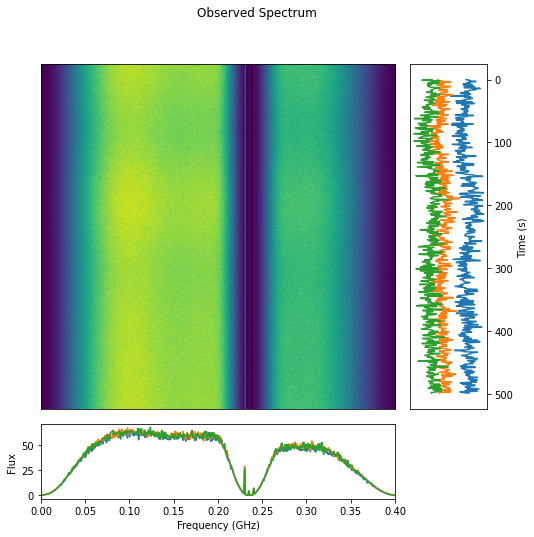

In [13]:
# Observed Source Spectrum
# noise spectrum
noiseSpectrum = np.random.normal(loc=0., scale=2., size=gainSpectrum.shape)

# bandpass spectrum
bpSpectrum = np.repeat(bandpassAmp * bsfAmp * rfiSpectrum, ntime).reshape(nchans, ntime)

# observed spectrum
obsSpectrum = bpSpectrum.T * ( (gainSpectrum * np.abs(brightness[:,:,0,0]+brightness[:,:,1,1])) + noiseSpectrum)

# local oscillator frequencies
lo = 1.1e9
ifFreqs = freqs - lo

# save spectrum for use in the next section
np.savez('analogue_spectrum.npz', obsSpectrum, ifFreqs)

fig, axes = plt.subplots(figsize=(8,8))

ax1 = plt.subplot2grid((5,5), (0,0), colspan=4, rowspan=4)
plt.imshow(np.abs(obsSpectrum), aspect='auto')
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)

ax2 = plt.subplot2grid((5,5), (4,0), colspan=4, rowspan=1)
plt.plot(ifFreqs/1e9, obsSpectrum[50, :])
plt.plot(ifFreqs/1e9, obsSpectrum[250, :])
plt.plot(ifFreqs/1e9, obsSpectrum[450, :])
plt.xlim(ifFreqs[0]/1e9, ifFreqs[-1]/1e9)
plt.ylabel('Flux')
plt.xlabel('Frequency (GHz)')

ax3 = plt.subplot2grid((5,5), (0,4), colspan=1, rowspan=4)
plt.plot(obsSpectrum[:, 130], np.arange(obsSpectrum.shape[0]))
plt.plot(obsSpectrum[:, 260], np.arange(obsSpectrum.shape[0]))
plt.plot(obsSpectrum[:, 390], np.arange(obsSpectrum.shape[0]))
ax3.get_xaxis().set_visible(False)
ax3.invert_yaxis()
ax3.yaxis.tick_right()
plt.ylabel('Time (s)')
ax3.yaxis.set_label_position('right')

plt.suptitle('Observed Spectrum')

System noise has hidden the smooth source structure. The LNA response has scaled the flux values and added a bit of ripple to the source. The bandpass filter has supressed the source response at the edges of the band. The notch filter has supressed the RFI signal and part of the source signal. The signals range from 0 MHz (DC) to 400 MHz due to the hetrodyne mixer.

We can see that the analogue front-end transforms the original astronomical signal into the observed signal. It is generally a time- and frequency-dependent transformation. The time and frequency dependence is due to the variation in response from the analogue electronic components used to filter, condition, and amplify the input voltage in order to digitally sample the signal. 

### 4 Digitisation

After signal conditioning in the analogue front-end, we are ready to capture the signal into a digital form so that we can perform the correlation. The term digitisation is worth reflecting upon: it is the process of taking a time-continuous, analogue signal, and converting it to a time-discrete voltage signal (which are 'digits' described by integers). The last analogue component is the *analogue to digital converter (ADC)*. A simple form of analogue-to-digital conversion is a cascading resistor ladder, which measures discrete steps in an analogue signal. Each output of the ladder triggers a bit value of either 0 or 1 - a digital signal is thus created. See Chapter 13 of [<cite data-cite='horowitz2015art'>The Art of Electronics</cite> &#10548;](http://artofelectronics.net/).

The dynamic range of an ADC is determined by the number of bits an input analogue signal can be digitized into. For an $n$-bit ADC there are $2^n$ possible digital values, by convention this range is $[-2^{n-1}, 2^{n-1}-1]$. Just as in other electronic components, an ADC has input range in which the resulting digitisation produces linear results. An astronomical signal needs to be amplified such that the analogue signal is within this linear range. The signal is then digitized: an example of a 4-bit (256 values) ADC is shown in the figure below.

Text(0.5, 0, 'Time Sample')

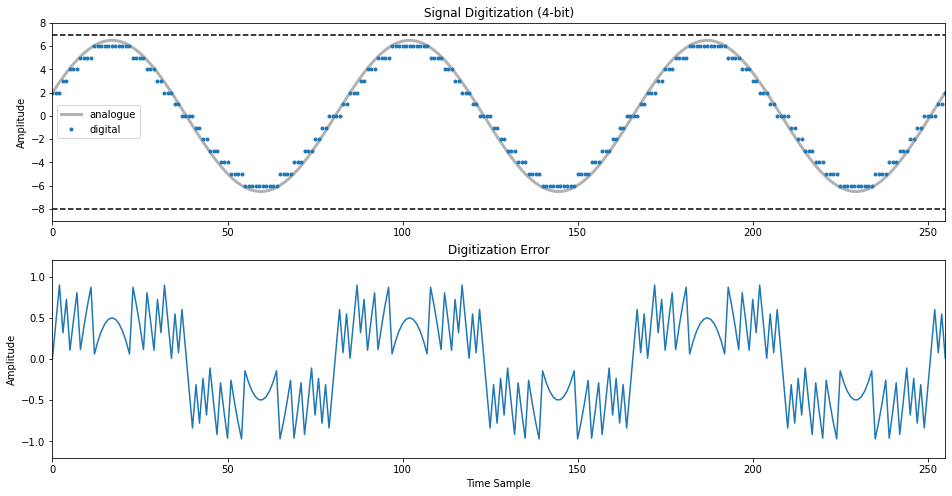

In [14]:
adcBits = 4 # number of bits in the ADC
adcMin = -1 * 2**(adcBits-1) # minimum ADC value
adcMax = 2**(adcBits-1) - 1 # maximumx ADC value

nsamp = 256 # number of time samples
phi0 = .1*np.pi # starting phase
dphi = 6.*np.pi # length
phis = np.linspace(0, dphi, nsamp)
amp = 6.5 # signal amplitude

analogueSignal = amp*np.sin(phis+phi0)
digitalSignal = analogueSignal.astype(int)

fig, axes = plt.subplots(figsize=(16,8))

plt.subplot(2, 1, 1)
plt.plot(analogueSignal, c='k', label='analogue', linewidth=3, alpha=0.3)
plt.plot(digitalSignal, '.', label='digital', linewidth=3)
plt.ylim(adcMin-1, adcMax+1)
plt.xlim(0, nsamp-1)
plt.axhline(adcMin, ls='--', c='k')
plt.axhline(adcMax, ls='--', c='k')
plt.title('Signal Digitization (4-bit)')
plt.ylabel('Amplitude')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(analogueSignal-digitalSignal)
plt.xlim(0, nsamp-1)
plt.ylim(-1.2, 1.2)
plt.title('Digitization Error')
plt.ylabel('Amplitude')
plt.xlabel('Time Sample')

The digitization results in time-discrete samples. The amplitude of each sample is the closest step in the ADC to the analogue amplitude. This results in *digitization error* as the conversion to digital results in information loss. To reduce the digitisation error, the maximum number of steps in the ADC should be used. This requires knowledge of the input signal amplitude. If the signal is too weak, then only a few bits will be used in digitisation and the dynamic range is not being used optimally; this is shown in the figure below.

Text(0.5, 0, 'Time Sample')

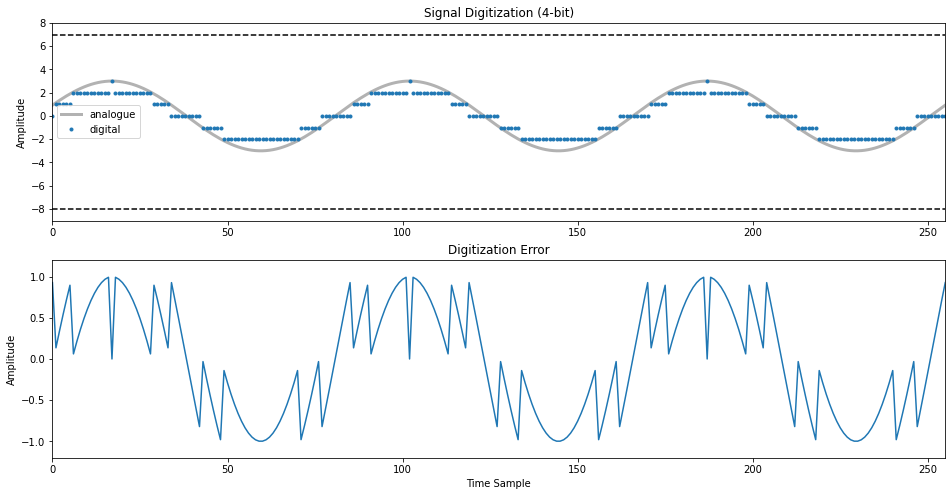

In [15]:
adcBits = 4 # number of bits in the ADC
adcMin = -1 * 2**(adcBits-1) # minimum ADC value
adcMax = 2**(adcBits-1) - 1 # maximumx ADC value

nsamp = 256 # number of time samples
phi0 = .1*np.pi # starting phase
dphi = 6.*np.pi # length
phis = np.linspace(0, dphi, nsamp)
amp = 3. # signal amplitude

analogueSignal = amp*np.sin(phis+phi0)
digitalSignal = analogueSignal.astype(int)

fig, axes = plt.subplots(figsize=(16,8))

plt.subplot(2, 1, 1)
plt.plot(analogueSignal, c='k', label='analogue', linewidth=3, alpha=0.3)
plt.plot(digitalSignal, '.', label='digital', linewidth=3)
plt.ylim(adcMin-1, adcMax+1)
plt.xlim(0, nsamp-1)
plt.axhline(adcMin, ls='--', c='k')
plt.axhline(adcMax, ls='--', c='k')
plt.title('Signal Digitization (4-bit)')
plt.ylabel('Amplitude')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(analogueSignal-digitalSignal)
plt.xlim(0, nsamp-1)
plt.ylim(-1.2, 1.2)
plt.title('Digitization Error')
plt.ylabel('Amplitude')
plt.xlabel('Time Sample')

Another solution to reduce digitization error is to use an ADC with more bits, such as the 6-bit ADC figure below. As the number of bits increases, digitisation will eventually approach the true analogue signal amplitude.

Text(0.5, 0, 'Time Sample')

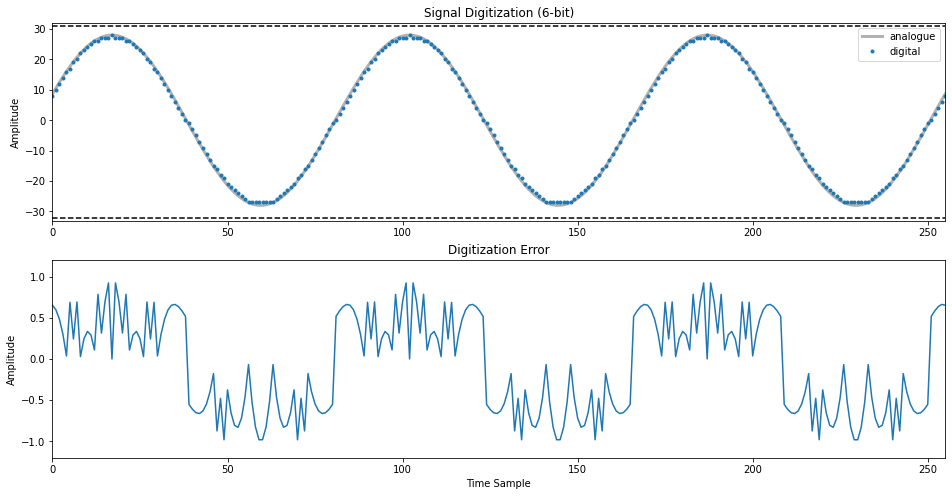

In [16]:
adcBits = 6 # number of bits in the ADC
adcMin = -1 * 2**(adcBits-1) # minimum ADC value
adcMax = 2**(adcBits-1) - 1 # maximumx ADC value

nsamp = 256 # number of time samples
phi0 = .1*np.pi # starting phase
dphi = 6.*np.pi # length
phis = np.linspace(0, dphi, nsamp)
amp = 28 # signal amplitude

analogueSignal = amp*np.sin(phis+phi0)
digitalSignal = analogueSignal.astype(int)

fig, axes = plt.subplots(figsize=(16,8))

plt.subplot(2, 1, 1)
plt.plot(analogueSignal, c='k', label='analogue', linewidth=3, alpha=0.3)
plt.plot(digitalSignal, '.', label='digital', linewidth=3)
plt.ylim(adcMin-1, adcMax+1)
plt.xlim(0, nsamp-1)
plt.axhline(adcMin, ls='--', c='k')
plt.axhline(adcMax, ls='--', c='k')
plt.title('Signal Digitization (6-bit)')
plt.ylabel('Amplitude')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(analogueSignal-digitalSignal)
plt.xlim(0, nsamp-1)
plt.ylim(-1.2, 1.2)
plt.title('Digitization Error')
plt.ylabel('Amplitude')
plt.xlabel('Time Sample')

A problem in radio astronomy is that we wish to maximize the dynamic range of the ADC for a weak astronomical signal, but observe in an environment with strong RFI which dominate the time-domain telescope signal. We need to sample the full dynamic range of the RFI signal. If the maximum/minimum ADC value is smaller than the RFI signal then the RFI will *saturate* the ADC, causing the output of the ADC to sit at the highest or lowest value and no sky signal to be captured: this is shown in the figure below. This results in *spectral leakage*, where a signal which is located at a specific frequency 'leaks' into nearby frequencies due to instrumental effects. A strong RFI source is usually a strong sinusoidal wave. When we take the Fourier transform of that signal, a strong $\delta$-function is produced in the resulting spectrum, isolated to a single frequency channel. If the ADC is saturated, then the RFI sinusoid will be clipped and turn into a square wave, the Fourier transform of which is similar to the Fourier transform of a boxcar function: a sinc function. A sinc function has longer extended wings - these will leak into the other channels. 

Text(0.5, 0, 'Time Sample')

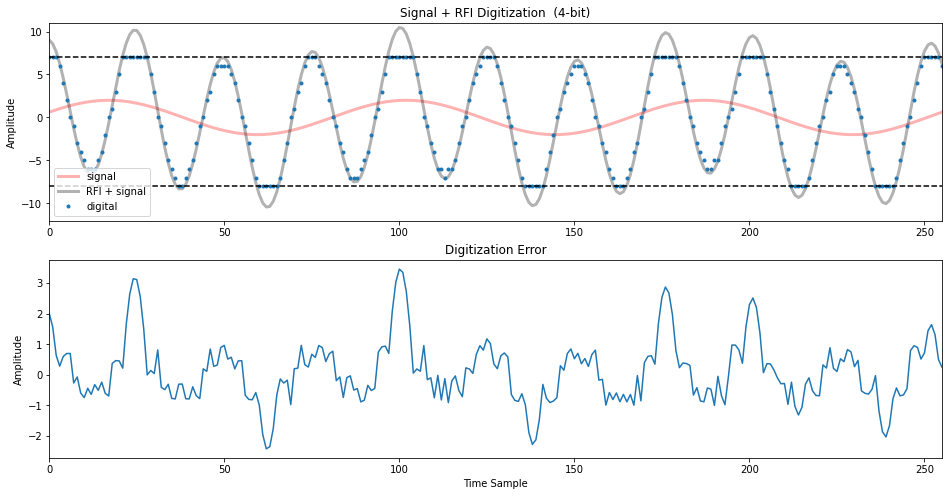

In [17]:
adcBits = 4 # number of bits in the ADC
adcMin = -1 * 2**(adcBits-1) # minimum ADC value
adcMax = 2**(adcBits-1) - 1 # maximumx ADC value

amp = 2. # signal amplitude
rfiAmp = 8.5 # RFI signal amplitude
rfiPhi0 = 1.35*np.pi
rfiFreq = 3.37 # frequecy relative to signal frequency

analogueSignal = rfiAmp*np.sin(rfiFreq*(phis+rfiPhi0)) + amp*np.sin(phis+phi0)
digitalSignal = analogueSignal.astype(int).clip(adcMin, adcMax)

fig, axes = plt.subplots(figsize=(16,8))

plt.subplot(2, 1, 1)
plt.plot(amp*np.sin(phis+phi0), c='r', label='signal', linewidth=3, alpha=0.3)
plt.plot(analogueSignal, c='k', label='RFI + signal', linewidth=3, alpha=0.3)
plt.plot(digitalSignal, '.', label='digital', linewidth=3)
plt.ylim(adcMin-4, adcMax+4)
plt.xlim(0, nsamp-1)
plt.axhline(adcMin, ls='--', c='k')
plt.axhline(adcMax, ls='--', c='k')
plt.title('Signal + RFI Digitization  (4-bit)')
plt.ylabel('Amplitude')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(analogueSignal-digitalSignal)
plt.xlim(0, nsamp-1)
plt.title('Digitization Error')
plt.ylabel('Amplitude')
plt.xlabel('Time Sample')

Not only does saturation cause spectral leakage, but there is significant digitisation error. The naive solution is to attenuate the in-out signal such that the RFI does not cause the ADC to saturate. If we turn off the RFI, however, we can see in the figure below that the sky signal is not well-sampled by the ADC. We are not using the full dynamic range of the ADC. Again, the solution is to use an ADC with more bits to balance RFI from saturating and sampling the sky signal to a sufficient level.

Text(0.5, 0, 'Time Sample')

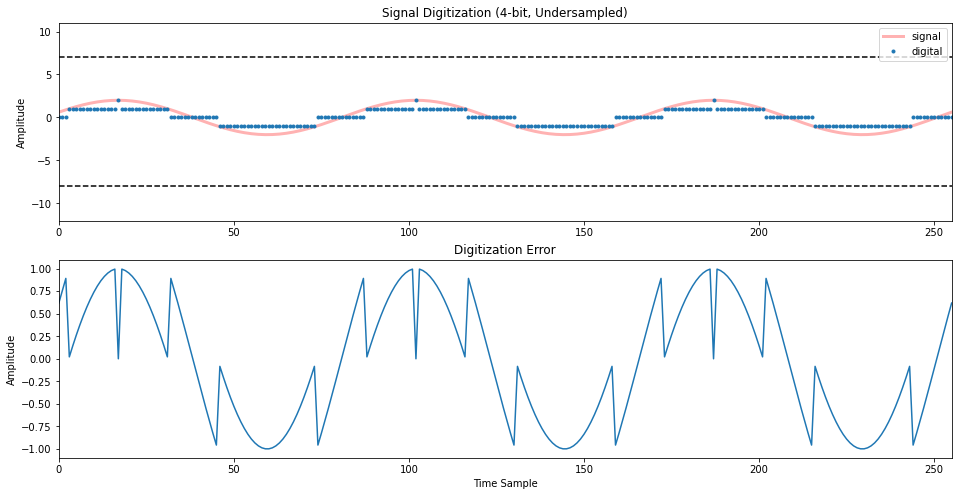

In [18]:
analogueSignal = amp*np.sin(phis+phi0)
digitalSignal = analogueSignal.astype(int).clip(adcMin, adcMax)

fig, axes = plt.subplots(figsize=(16,8))

plt.subplot(2, 1, 1)
plt.plot(analogueSignal, c='r', label='signal', linewidth=3, alpha=0.3)
plt.plot(digitalSignal, '.', label='digital', linewidth=3)
plt.ylim(adcMin-4, adcMax+4)
plt.xlim(0, nsamp-1)
plt.axhline(adcMin, ls='--', c='k')
plt.axhline(adcMax, ls='--', c='k')
plt.title('Signal Digitization (4-bit, Undersampled)')
plt.ylabel('Amplitude')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(analogueSignal-digitalSignal)
plt.xlim(0, nsamp-1)
plt.title('Digitization Error')
plt.ylabel('Amplitude')
plt.xlabel('Time Sample')

A typical, modern ADC used for radio astronomy will have 8-12 bits. This is necessary for the strong -RFI environment many telescopes operate in. There is an additional issue for *wide-band system*, which are telescopes which cover significant fractional bandwidth. Most astronomical radio sources are continuum sources, i.e. the spectrum of the source is smooth and continuous in frequency. One way to improve the sensitivity of the telescope, as per the radiometer equation, is to increase the observing bandwidth. This is a fine idea, but means that there is necessarily more power being observed by the telescope, and thus requires an ADC with increased dynamic range compared to a narrow-band system.

In the past, all the electronic components of a radio telescope were analogue. As we have seen, analogue components add noise and distort signals. What we really want is to digitise the observed signal. This has the advantage of allowing us to perfectly control the signal, at the cost of turning a continuous signal into a discrete one. Analogue components are still required to amplify and filter the signal, but modern radio telescope design aims to convert the signal to digital as soon as possible. Once we have a digital signal we are free to do what we want with the signal - in our case, correlate it.